<a href="https://colab.research.google.com/github/Pratham-04/CS711A-Fall-2020/blob/main/Project/Process_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pykalman

Mounted at /content/drive
     |████████████████████████████████| 235kB 9.7MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48463 sha256=f1802952b2982b96c7c291dabd1010e9f16750dd0ea5a01bf34dd0ef39282471
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [ ]:
import numpy as np

# filename = r"/content/drive/MyDrive/CS711A Project/Games/game1.txt"

def readData(filename):

    strats = []
    rewards = []
    #print(filename)
    f = open(filename, "r")
    for i in range(30):
        
        line1 = f.readline()
        line2 = f.readline()
        
        data1 = line1.split(" ")
        data2 = line2.split(" ")
        data1[1] = data1[1].rstrip()
        data2[1] = data2[1].rstrip()
        data2 = [float(i) for i in data2]
        
        strats.append(data1)
        rewards.append(data2)   

    f.close()

    rew1 = []
    rew2 = []
    m1 = []
    m2 = []
    #print(rewards)

    for i in range(30):
        rew1.append(rewards[i][0])
        rew2.append(rewards[i][1])
        if strats[i][0] == '0':
            m1.append(False)
        else:
            m1.append(True)
        
        if strats[i][1] == '0':
            m2.append(False)
        else:
            m2.append(True)

    #print(strats)
    patchA1 = np.ma.masked_array(rew1, mask = m1)
    patchA2 = np.ma.masked_array(rew1, mask = [not elem for elem in m1])
    patchB1 = np.ma.masked_array(rew2, mask = m2)
    patchB2 = np.ma.masked_array(rew2, mask = [not elem for elem in m2])
        
    return strats, rewards, patchA1, patchA2, patchB1, patchB2        
    

# strats, rewards, patchA1, patchA2, patchB1, patchB2 = readData(filename)



In [ ]:
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import math

def fit_egreedy(patchA1, patchA2, patchB1, patchB2, strats):

    kfa1 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )
    kfb1 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )
    kfa2 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )

    kfb2 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )
    #print(patchA1)

    patchA1_mean = 16*np.ones(30)
    patchA1_cov = 25*np.ones(30)
    patchB1_mean = 16*np.ones(30)
    patchB1_cov = 25*np.ones(30)
    patchA2_mean = 16*np.ones(30)
    patchA2_cov = 25*np.ones(30)
    patchB2_mean = 16*np.ones(30)
    patchB2_cov = 25*np.ones(30)
    eps1 = np.linspace(0,1,50)
    prob_baye1 = 0.02*np.ones(50)
    eps2 = np.linspace(0,1,50)
    prob_baye2 = 0.02*np.ones(50)

    #print(patchA1.size)

    for i in range(1, 30):

        if i>0:
            patchA1_mean[i], patchA1_cov[i] = kfa1.filter_update(patchA1_mean[i-1], patchA1_cov[i-1], patchA1[i-1])
            patchB1_mean[i], patchB1_cov[i] = kfb1.filter_update(patchB1_mean[i-1], patchB1_cov[i-1], patchB1[i-1])
            patchA2_mean[i], patchA2_cov[i] = kfa2.filter_update(patchA2_mean[i-1], patchA2_cov[i-1], patchA2[i-1])
            patchB2_mean[i], patchB2_cov[i] = kfb2.filter_update(patchB2_mean[i-1], patchB2_cov[i-1], patchB2[i-1])

        if patchA1_mean[i] > patchB1_mean[i]:
            strat_pred1 = '0'
        elif patchA1_mean[i] == patchB1_mean[i]:
            strat_pred1 = np.random.choice(['0', '1'])
        else:
            strat_pred1 = '1'

        if strats[i][0] == strat_pred1:
            for j in range(50):
                prob_baye1[j] = prob_baye1[j]*(1 - (eps1[j]/2))
        else:
            for j in range(50):
                prob_baye1[j] = prob_baye1[j]*(eps1[j]/2)
        
        
        x1 = sum(prob_baye1)
        for j in range(50):
            prob_baye1[j] = prob_baye1[j]/x1

        if patchA2_mean[i] > patchB2_mean[i]:
            strat_pred2 = '0'
        elif patchA2_mean[i] == patchB2_mean[i]:
            strat_pred2 = np.random.choice(['0', '1'])
        else:
            strat_pred2 = '1'

        if strats[i][1] == strat_pred2:
            for j in range(50):
                prob_baye2[j] = prob_baye2[j]*(1 - (eps2[j]/2))
        else:
            for j in range(50):
                prob_baye2[j] = prob_baye2[j]*(eps2[j]/2)

        x2 = sum(prob_baye2)
        for j in range(50):
            prob_baye2[j] = prob_baye2[j]/x2

    #plt.plot(prob_baye1)
    #plt.plot(prob_baye2)
    eps_opt1 = np.argmax(prob_baye1)*0.02
    eps_opt2 = np.argmax(prob_baye2)*0.02

    return eps_opt1, eps_opt2
    
# print(patchA1_mean)
# eps_opt1, eps_opt2 = fit_egreedy(patchA1, patchA2, patchB1, patchB2, strats)
#print(eps_opt1)
#print(eps_opt2)

1
[['0', '0'], ['0', '1'], ['1', '1'], ['1', '1'], ['0', '0'], ['0', '0'], ['1', '0'], ['0', '1'], ['1', '0'], ['0', '0'], ['1', '1'], ['0', '0'], ['0', '0'], ['0', '1'], ['1', '0'], ['0', '0'], ['1', '0'], ['1', '0'], ['0', '1'], ['0', '0'], ['1', '1'], ['0', '0'], ['0', '0'], ['1', '0'], ['1', '0'], ['0', '0'], ['0', '0'], ['1', '0'], ['1', '0'], ['0', '0']]
[[10.0, 10.0], [19.84, 13.62], [6.16, 6.16], [4.93, 4.93], [10.68, 10.68], [10.35, 10.35], [8.91, 20.0], [19.75, 8.23], [7.87, 20.38], [10.01, 10.01], [3.73, 3.73], [10.1, 10.1], [9.07, 9.07], [17.74, 2.63], [3.17, 17.61], [8.14, 8.14], [4.1, 14.09], [4.14, 14.74], [14.1, 5.75], [7.13, 7.13], [2.46, 2.46], [7.36, 7.36], [7.15, 7.15], [5.7, 14.16], [5.09, 12.04], [5.95, 5.95], [4.83, 4.83], [6.7, 9.53], [4.62, 9.77], [4.62, 4.62]]


2
[['0', '1'], ['0', '0'], ['0', '0'], ['0', '1'], ['0', '1'], ['1', '0'], ['1', '1'], ['0', '0'], ['0', '0'], ['1', '0'], ['1', '1'], ['1', '0'], ['0', '0'], ['0', '1'], ['0', '1'], ['0', '1'], ['0', 

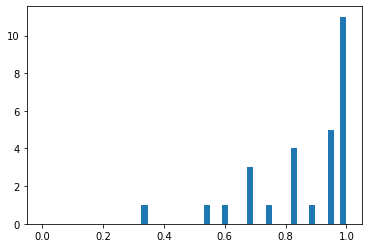

In [ ]:
import statistics
epsilons = []
# a1, a2, b1, b2
tm = np.zeros((14,4))
tc = np.zeros((14,4))
om = np.zeros((14,4))
oc = np.zeros((14,4))

for t in range(1,15):
    filename = r"/content/drive/MyDrive/CS711A Project/Games/game" + str(t) + ".txt"
    #print(filename)
    strats_n, rewards_n, patchA1_n, patchA2_n, patchB1_n, patchB2_n  = readData(filename)
    kfa1 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )
    kfb1 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )
    kfa2 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )

    kfb2 = KalmanFilter(
        n_dim_state = 1,
        n_dim_obs = 1,
        em_vars = ['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    )
    kfa1.em(patchA1_n)
    kfa2.em(patchA2_n)
    kfb1.em(patchB1_n)
    kfb2.em(patchB2_n)

    tm[t-1][0] = kfa1.transition_matrices
    tm[t-1][1] = kfa2.transition_matrices
    tm[t-1][2] = kfb1.transition_matrices
    tm[t-1][3] = kfb2.transition_matrices
    tc[t-1][0] = kfa1.transition_covariance
    tc[t-1][1] = kfa2.transition_covariance
    tc[t-1][2] = kfb1.transition_covariance
    tc[t-1][3] = kfb2.transition_covariance
    om[t-1][0] = kfa1.observation_matrices
    om[t-1][1] = kfa2.observation_matrices
    om[t-1][2] = kfb1.observation_matrices
    om[t-1][3] = kfb2.observation_matrices
    oc[t-1][0] = kfa1.observation_covariance
    oc[t-1][1] = kfa2.observation_covariance
    oc[t-1][2] = kfb1.observation_covariance
    oc[t-1][3] = kfb2.observation_covariance
    epsilon1, epsilon2 = fit_egreedy(patchA1_n, patchA2_n, patchB1_n, patchB2_n, strats_n)
    epsilons.append(epsilon1)
    epsilons.append(epsilon2)
    print(t)
    print(strats_n)
    print(rewards_n)
    print('\n')

# print(epsilons)
# plt.hist(epsilons, bins = np.linspace(0,1,50))
eps_mean = statistics.mean(epsilons)
eps_cov = statistics.stdev(epsilons)
# print(eps_mean, eps_cov)

# print(tm)
# print(tc)
# print(om)
# print(oc)








In [ ]:
mean_tm = []
mean_tc = []
mean_om = []
mean_oc = []
for l in range(4):
    mean_tm.append(statistics.mean(tm[:][l]))
    mean_tc.append(statistics.mean(tc[:][l]))
    mean_om.append(statistics.mean(om[:][l]))
    mean_oc.append(statistics.mean(oc[:][l]))

print(mean_tm)
print(mean_tc)
print(mean_om)
print(mean_oc)

    

[0.9558036282641713, 0.9475594560122231, 0.9360129609134596, 0.9011297059989769]
[3.266965089461436, 2.4665969002094967, 4.389718824029311, 2.6238772978107168]
[1.3657745605840546, 1.6229340398234333, 1.5465626541860327, 1.6567636139937965]
[17.046294600024897, 12.120186059784064, 15.318890036378399, 13.805276234757352]
